In [1]:
import os
import random
import shutil
import re
import pandas as pd
import numpy as np

## clean* list of all files with no duplicates
the files have a lot of duplicates. remove those

input: 'rer_all_audio_files_list_upd.csv' from nuria

output: a pandas df 'no_duplicates'

In [2]:
data=pd.read_csv('rer_all_audio_files_list_upd.csv')

data.drop_duplicates(inplace=True) #remove duplicates in place
data.dropna(subset=['student_id'], inplace=True) #remove NaN subjects

duplicates = data[data.duplicated(subset=['student_id', 'task_name', 'item_name', 'semester'], keep=False)]

duplicates=duplicates.sort_values(by=['student_id', 'task_name', 'item_name', 'semester'])

#duplicates.to_csv('rer_duplicate_items.csv', index=False)

# Get rows of df1 which are not in df2
no_duplicates = data.merge(duplicates, how='outer', indicator=True).query("_merge == 'left_only'").drop('_merge', axis=1)

#no_duplicates
#no_duplicates.to_csv('no_duplicates.csv', index=False)

# Split the strings in col1 based on ':'
no_duplicates[['task', 'new_col2']] = no_duplicates['task_name'].str.split(':', expand=True)

# Split the strings in new_col2 based on '('
no_duplicates[['task', 'new_col3']] = no_duplicates['task'].str.split('(', expand=True)

# Drop the unwanted columns
no_duplicates.drop(['new_col2', 'new_col3'], axis=1, inplace=True)

# Replace all '_' and ' ' characters in col1 with '' and also remove Practice and Items
no_duplicates['task'] = no_duplicates['task'].str.replace('-', '').str.replace(' ', '').str.replace('Items', '').str.replace('Practice', '')


# clean the updated files list assessment by assessment
the files also have incopnsistent naming conventions and bad files that cannot be linked to scores. remove those

outputs: 4 *_clean_clean.csv cleaned file lists for each assessment for the kaggle challenge

## non word repetition

In [3]:
# Filter rows of df where task is 'NonwordRepetition', 'SentenceRepetition', 'Deletion', or 'Blending'
#new_df = no_duplicates[no_duplicates['task'].isin(['NonwordRepetition', 'SentenceRepetition', 'Deletion', 'Blending'])]
working_df = no_duplicates[no_duplicates['task'].isin(['NonwordRepetition'])]
# Split the strings in col1 based on '_'
working_df['item'] = working_df['item_name'].str.split('_', expand=True)[2]
working_df['assessment_season'] = working_df['assessment_name'].str.extract('(Fall|Winter|End)')
working_df['assessment_season'] = working_df['assessment_season'].str.lower()
working_df['semester_season'] = working_df['semester'].str.extract('(fall|winter|spring|end)')
working_df['true_season'] = working_df['semester_season'].fillna(working_df['assessment_season']) #combine semester and assessment season columns
working_df = working_df[~working_df['item'].isin(['S', 'A'])] #remove where item is 'S' or 'A' these don't line up with scores
where_nwr_bad=working_df['item'].isin(['0013','0009', '0003', '0006', '0027', '0024', '0025', '0018', '0001','0017', '0015', '0016','9003', '9002' ])
working_df['new_item']= working_df[where_nwr_bad]['item_name'].str.split('_', expand=True)[3]
working_df['item'] = working_df['item'].replace(['0013','0009', '0003', '0006', '0027', '0024', '0025', '0018', '0001','0017', '0015', '0016','9003', '9002'], np.nan)
working_df['item_name'] = working_df['item'].fillna(working_df['new_item']) #combine semester and assessment season columns
working_df = working_df[~working_df['item_name'].isin(['a'])] #remove where item is 'S' or 'A' these don't line up with scores
working_df['year'] = working_df['assessment_name'].str.extract('(2018|2019|2020|2021|2022|2023)')

#load all_files for creating the folders column
all_files=pd.read_csv('all_files.csv',header=None,names=['folder','audio_string'])
# merge the two dataframes on the 'key' column
working_df = pd.merge(working_df, all_files, on='audio_string', how='left')

working_df = working_df.drop(['item', 'new_item'], axis=1)

col_task = working_df.pop('task')
col_grade = working_df.pop('grade')
col_audio_string = working_df.pop('audio_string')
col_student_id = working_df.pop('student_id')
col_true_season = working_df.pop('true_season')
col_folder = working_df.pop('folder')

# insert columns B and D at the first position
working_df.insert(0, 'task', col_task)
working_df.insert(0, 'folder', col_folder)
working_df.insert(0, 'true_season', col_true_season)
working_df.insert(0, 'student_id', col_student_id)
working_df.insert(0, 'audio_string', col_audio_string)
working_df.insert(0, 'grade', col_grade)

working_df.to_csv('NWR_clean_clean.csv', index=False)

/tmp/ipykernel_28202/3145843639.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['item'] = working_df['item_name'].str.split('_', expand=True)[2]
/tmp/ipykernel_28202/3145843639.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['assessment_season'] = working_df['assessment_name'].str.extract('(Fall|Winter|End)')
/tmp/ipykernel_28202/3145843639.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

## Sentence rep

In [4]:
# Filter rows of df where task is 'NonwordRepetition', 'SentenceRepetition', 'Deletion', or 'Blending'
#new_df = no_duplicates[no_duplicates['task'].isin(['NonwordRepetition', 'SentenceRepetition', 'Deletion', 'Blending'])]
working_df = no_duplicates[no_duplicates['task'].isin(['SentenceRepetition'])]

# Split the strings in col1 based on '_'


working_df['assessment_season'] = working_df['assessment_name'].str.extract('(Fall|Winter|End)')
working_df['assessment_season'] = working_df['assessment_season'].str.lower()
working_df['semester_season'] = working_df['semester'].str.extract('(fall|winter|spring|end)')
working_df['true_season'] = working_df['semester_season'].fillna(working_df['assessment_season']) #combine semester and assessment season columns

working_df['item_name'] = working_df['item_name'].str.replace('_v2', '')
working_df['item_name'] = working_df['item_name'].str.replace('_012L', '')
working_df['item_name'] = working_df['item_name'].str.replace('_0L', '')
working_df['item_name'] = working_df['item_name'].str.replace('_01', '')
working_df['item_name'] = working_df['item_name'].str.replace('_0', '')
working_df['item_name'] = working_df['item_name'].str.replace('_1', '')
working_df['item_name'] = working_df['item_name'].str.replace('_2', '')
working_df['item_name'] = working_df['item_name'].str.replace('5', '')

working_df['item_name'] = working_df['item_name'].str.split('_').str[-1]
# working_df['item'] = working_df['item_name'].str.split('_', expand=True)[2]
working_df = working_df[~working_df['item_name'].isin(['U', 'U2', 'Diego', 'Practice1', 'Practice2' ])] #remove where item is 'S' or 'A' these don't line up with scores
working_df['year'] = working_df['date'].str.extract('(2018|2019|2020|2021|2022|2023)')

# where_nwr_bad=working_df['item'].isin(['0013','0009', '0003', '0006', '0027', '0024', '0025', '0018', '0001','0017', '0015', '0016','9003', '9002' ])
# working_df['new_item']= working_df[where_nwr_bad]['item_name'].str.split('_', expand=True)[3]
# working_df['item'] = working_df['item'].replace(['0013','0009', '0003', '0006', '0027', '0024', '0025', '0018', '0001','0017', '0015', '0016','9003', '9002'], np.nan)
# working_df['true_item'] = working_df['item'].fillna(working_df['new_item']) #combine semester and assessment season columns
all_files=pd.read_csv('all_files.csv',header=None,names=['folder','audio_string'])
working_df = pd.merge(working_df, all_files, on='audio_string', how='left')

col_task = working_df.pop('task')
col_grade = working_df.pop('grade')
col_audio_string = working_df.pop('audio_string')
col_student_id = working_df.pop('student_id')
col_true_season = working_df.pop('true_season')
col_folder = working_df.pop('folder')

# insert columns B and D at the first position
working_df.insert(0, 'task', col_task)
working_df.insert(0, 'folder', col_folder)
working_df.insert(0, 'true_season', col_true_season)
working_df.insert(0, 'student_id', col_student_id)
working_df.insert(0, 'audio_string', col_audio_string)
working_df.insert(0, 'grade', col_grade)

working_df.to_csv('SRT_clean_clean.csv', index=False)

/tmp/ipykernel_28202/3038809114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['assessment_season'] = working_df['assessment_name'].str.extract('(Fall|Winter|End)')
/tmp/ipykernel_28202/3038809114.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['assessment_season'] = working_df['assessment_season'].str.lower()
/tmp/ipykernel_28202/3038809114.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

## Blending

In [5]:
# Filter rows of df where task is 'NonwordRepetition', 'SentenceRepetition', 'Deletion', or 'Blending'
#new_df = no_duplicates[no_duplicates['task'].isin(['NonwordRepetition', 'SentenceRepetition', 'Deletion', 'Blending'])]
working_df = no_duplicates[no_duplicates['task'].isin(['Blending'])]

# Split the strings in col1 based on '_'


working_df['assessment_season'] = working_df['assessment_name'].str.extract('(Fall|Winter|End)')
working_df['assessment_season'] = working_df['assessment_season'].str.lower()
working_df['semester_season'] = working_df['semester'].str.extract('(fall|winter|spring|end)')
working_df['true_season'] = working_df['semester_season'].fillna(working_df['assessment_season']) #combine semester and assessment season columns
working_df['item_name'] = working_df['item_name'].str.replace('_0L', '')
working_df['item_name'] = working_df['item_name'].str.replace('_0', '')

# working_df['item_name'] = working_df['item_name'].str.replace('_v2', '')
# working_df['item_name'] = working_df['item_name'].str.replace('_012L', '')
# working_df['item_name'] = working_df['item_name'].str.replace('_0L', '')
# working_df['item_name'] = working_df['item_name'].str.replace('_01', '')
# working_df['item_name'] = working_df['item_name'].str.replace('_0', '')
# working_df['item_name'] = working_df['item_name'].str.replace('_1', '')
# working_df['item_name'] = working_df['item_name'].str.replace('_2', '')
# working_df['item_name'] = working_df['item_name'].str.replace('5', '')

working_df['item_name'] = working_df['item_name'].str.split('_').str[-1]
working_df['item_name'] = working_df['item_name'].str.lower()

# # working_df['item'] = working_df['item_name'].str.split('_', expand=True)[2]
working_df = working_df[~working_df['item_name'].isin(['d', 'u', 'p'])] #remove where item is 'S' or 'A' these don't line up with scores
working_df['year'] = working_df['assessment_name'].str.extract('(2018|2019|2020|2021|2022|2023)')

# # where_nwr_bad=working_df['item'].isin(['0013','0009', '0003', '0006', '0027', '0024', '0025', '0018', '0001','0017', '0015', '0016','9003', '9002' ])
# # working_df['new_item']= working_df[where_nwr_bad]['item_name'].str.split('_', expand=True)[3]
# # working_df['item'] = working_df['item'].replace(['0013','0009', '0003', '0006', '0027', '0024', '0025', '0018', '0001','0017', '0015', '0016','9003', '9002'], np.nan)
# # working_df['true_item'] = working_df['item'].fillna(working_df['new_item']) #combine semester and assessment season columns
all_files=pd.read_csv('all_files.csv',header=None,names=['folder','audio_string'])
working_df = pd.merge(working_df, all_files, on='audio_string', how='left')

col_task = working_df.pop('task')
col_grade = working_df.pop('grade')
col_audio_string = working_df.pop('audio_string')
col_student_id = working_df.pop('student_id')
col_true_season = working_df.pop('true_season')
col_folder = working_df.pop('folder')

# insert columns B and D at the first position
working_df.insert(0, 'task', col_task)
working_df.insert(0, 'folder', col_folder)
working_df.insert(0, 'true_season', col_true_season)
working_df.insert(0, 'student_id', col_student_id)
working_df.insert(0, 'audio_string', col_audio_string)
working_df.insert(0, 'grade', col_grade)

working_df.to_csv('BLE_clean_clean.csv', index=False)

/tmp/ipykernel_28202/403177495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['assessment_season'] = working_df['assessment_name'].str.extract('(Fall|Winter|End)')
/tmp/ipykernel_28202/403177495.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['assessment_season'] = working_df['assessment_season'].str.lower()
/tmp/ipykernel_28202/403177495.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

## Deletion

In [6]:
# Filter rows of df where task is 'NonwordRepetition', 'SentenceRepetition', 'Deletion', or 'Blending'
#new_df = no_duplicates[no_duplicates['task'].isin(['NonwordRepetition', 'SentenceRepetition', 'Deletion', 'Blending'])]
working_df = no_duplicates[no_duplicates['task'].isin(['Deletion'])]

# Split the strings in col1 based on '_'


working_df['assessment_season'] = working_df['assessment_name'].str.extract('(Fall|Winter|End)')
working_df['assessment_season'] = working_df['assessment_season'].str.lower()
working_df['semester_season'] = working_df['semester'].str.extract('(fall|winter|spring|end)')
working_df['true_season'] = working_df['semester_season'].fillna(working_df['assessment_season']) #combine semester and assessment season columns


working_df['item_name'] = working_df['item_name'].str.replace('_v2', '')
working_df['item_name'] = working_df['item_name'].str.replace('_012L', '')
working_df['item_name'] = working_df['item_name'].str.replace('_0L', '')
working_df['item_name'] = working_df['item_name'].str.replace('_01', '')
working_df['item_name'] = working_df['item_name'].str.replace('_0', '')
working_df['item_name'] = working_df['item_name'].str.replace('_1', '')
working_df['item_name'] = working_df['item_name'].str.replace('_2', '')



working_df['item_name'] = working_df['item_name'].str.split('_').str[-1]
working_df['item_name'] = working_df['item_name'].str.lower()
working_df['item_name'] = working_df['item_name'].str.replace('1', '')
working_df['item_name'] = working_df['item_name'].str.replace('2', '')

# # # working_df['item'] = working_df['item_name'].str.split('_', expand=True)[2]
working_df = working_df[~working_df['item_name'].isin(['d', 'u', 'p', '9'])] #remove where item is 'S' or 'A' these don't line up with scores
working_df['year'] = working_df['assessment_name'].str.extract('(2018|2019|2020|2021|2022|2023)').astype(str)

# # # where_nwr_bad=working_df['item'].isin(['0013','0009', '0003', '0006', '0027', '0024', '0025', '0018', '0001','0017', '0015', '0016','9003', '9002' ])
# # # working_df['new_item']= working_df[where_nwr_bad]['item_name'].str.split('_', expand=True)[3]
# # # working_df['item'] = working_df['item'].replace(['0013','0009', '0003', '0006', '0027', '0024', '0025', '0018', '0001','0017', '0015', '0016','9003', '9002'], np.nan)
# # # working_df['true_item'] = working_df['item'].fillna(working_df['new_item']) #combine semester and assessment season columns
all_files=pd.read_csv('all_files.csv',header=None,names=['folder','audio_string'])
working_df = pd.merge(working_df, all_files, on='audio_string', how='left')

col_task = working_df.pop('task')
col_grade = working_df.pop('grade')
col_audio_string = working_df.pop('audio_string')
col_student_id = working_df.pop('student_id')
col_true_season = working_df.pop('true_season')
col_folder = working_df.pop('folder')

# insert columns B and D at the first position
working_df.insert(0, 'task', col_task)
working_df.insert(0, 'folder', col_folder)
working_df.insert(0, 'true_season', col_true_season)
working_df.insert(0, 'student_id', col_student_id)
working_df.insert(0, 'audio_string', col_audio_string)
working_df.insert(0, 'grade', col_grade)

working_df.to_csv('DEL_clean_clean.csv', index=False)

/tmp/ipykernel_28202/932121695.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['assessment_season'] = working_df['assessment_name'].str.extract('(Fall|Winter|End)')
/tmp/ipykernel_28202/932121695.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['assessment_season'] = working_df['assessment_season'].str.lower()
/tmp/ipykernel_28202/932121695.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

# Unify Scores
match up the given scores with the cleaned updated files lists

inputs: ['NWR','DEL','BLE','SRT']: f'{a}_clean.csv' score csvs from anna grace

outputs: 4 *_unified.csv files with all of the non-duplicate identifiable files with all info parsed and scores added

In [7]:
assessments=['NWR','DEL','BLE','SRT']
for a in assessments:
    scores_df=pd.read_csv(f'{a}_clean.csv')
    scores_df.rename(columns={'Student.Tracking.Id': 'student'}, inplace=True)
    # Extract the season from uniqueid
    scores_df['season'] = scores_df['uniqueid'].str.extract('(fall|spring|winter)')
    scores_df['year'] = scores_df['uniqueid'].str.extract('(18|19|20|21|22|23)')
    scores_df['year'] = scores_df['year'].apply(lambda x: pd.to_datetime(str(x), format='%y').strftime('%Y'))
    # Replace 'winter' with 'spring' in col1
    scores_df['season'] = scores_df['season'].replace('spring', 'winter')
    scores_df = scores_df.rename(columns={'Grade': 'grade'})
    scores_df = scores_df.rename(columns={'season': 'true_season'})
    scores_df = scores_df.rename(columns={'student': 'student_id'})
    scores_df_melt = scores_df.melt(id_vars=['uniqueid', 'student_id', 'grade', 'true_season', 'year'], var_name='item_name', value_name='score')
    
    #remove NaNs
    scores_df_melt = scores_df_melt[scores_df_melt['score'].notna()]
    
    files_df=pd.read_csv(f'{a}_clean_clean.csv')
    files_scores = pd.merge(files_df.astype(str), scores_df_melt.astype(str), on=['student_id', 'grade', 'true_season','item_name','year'], how='left')
    # get a dataframe where all of the values of the column 'score' are NaN
    files_scores_nan = files_scores[files_scores['score'].isna()]
    #files_scores_nan
    # get a dataframe where all of the values of the column 'score' are not NaN
    files_scores_not_nan = files_scores[files_scores['score'].notna()]
    
    files_scores_not_nan = files_scores_not_nan.drop(['assessment_season','semester_season'], axis=1)

    #REMOVE ALL DUPLCIATES FOR NOW
    files_scores_not_nan.drop_duplicates(subset=['audio_string'],inplace=True,keep=False)
    
    col_year = files_scores_not_nan.pop('year')
    files_scores_not_nan.insert(0, 'year', col_year)

    files_scores_not_nan.to_csv(f'{a}_unified.csv', index=False)

In [8]:
#combine all 4 files into one unified file

In [18]:
assessments = ['NWR', 'DEL', 'BLE', 'SRT']
combined = pd.concat([pd.read_csv(f'{a}_unified.csv') for a in assessments])
combined.to_csv('rer_kaggle.csv', index=False)
combined=pd.read_csv(f'rer_kaggle.csv')

# Check wav files

## are any stereo? #NOTE THIS CODE TAKES AWHILE, SKIP IT :P
if there is a stereo file it will print it out...

In [19]:
import os
import wave

#def check_wav_files(directory):
directory='/om/tmp/jsmentch/rer/Scores/'
for root, dirs, files in os.walk(directory):
    for file in files:            
        if file.endswith('.wav'):
            with wave.open(os.path.join(root, file), 'rb') as f:
                #if f.getparams()[0] != 1 or f.getparams()[1] != 2  or f.getparams()[2] != 16000:
                if f.getparams()[0] != 1:
                    print(f.getparams(), root, file)
#    return nchannels, sampwidth, framerate, filelist
#nchannels, sampwidth, framerate, filelist  = check_wav_files('/om/tmp/jsmentch/rer/Scores/')


KeyboardInterrupt



### no none are stereo!

### some are different sample rates... so we need to transcode all Most are at or above 16k. some are below. Will transcode to 16k
run move_transcode_files.sh

run sox_stats.sh

### after transcoding and getting sox stats, add sox stats to the master csv file rer_kaggle.csv

In [20]:
import sys
import os
import collections
import glob
import os
import librosa
import pandas as pd
import re

#function that extracts values from sox stats output .txt files
def get_stats(path):
    clipping='NaN'
    rms='NaN'
    peak_rms='NaN'
    trough_rms='NaN'
    length='NaN'
    dif_rms='NaN'
    clip_per_min='NaN'
    with open(path) as f:
        lines = f.readlines()
    try:
        clipping=int(''.join(list(filter(str.isdigit, lines[9]))))
        rms=float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', lines[4])[0])
        length=float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', lines[12])[0])
        clip_per_min= round( clipping/(length/60), 4)
        peak_rms=float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', lines[5])[0])
        trough_rms=float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', lines[6])[0])
        dif_rms=peak_rms-trough_rms
    except:
        pass
        #print(f"An exception occurred for {path}")
        # uncomment to log the errored (silent) files
        # with open("silent_files.txt", "a+") as file_object:
        #     # Move read cursor to the start of file.
        #     file_object.seek(0)
        #     # If file is not empty then append '\n'
        #     data = file_object.read(100)
        #     if len(data) > 0 :
        #         file_object.write("\n")
        #     # Append text at the end of file
        #     audio_file=path.replace("_sox_stats.txt",".wav")
        #     file_object.write(f"{audio_file}")
    return clipping, rms, peak_rms, trough_rms, length, dif_rms, clip_per_min

In [21]:
#combined=pd.read_csv(f'NWR_unified.csv')
combined=pd.read_csv(f'rer_kaggle.csv')

In [22]:
combined['clipping'] = pd.Series(dtype='object')
combined['rms'] = pd.Series(dtype='object')
combined['peak_rms'] = pd.Series(dtype='object')
combined['trough_rms'] = pd.Series(dtype='object')
combined['length'] = pd.Series(dtype='object')
combined['dif_rms'] = pd.Series(dtype='object')
combined['clip_per_min'] = pd.Series(dtype='object')

In [23]:
for index, row in combined.iterrows():
#for index, row in combined.head(3).iterrows():
    grade = row['grade']
    student_id = row['student_id']
    true_season = row['true_season']
    task = row['task']
    audio_string = row['audio_string']
    sox_string=audio_string.replace('.wav','_sox_stats.txt')
    sox_path=f'../rer_kaggle/data/sub-{student_id}/ses-{grade}_{true_season}/task-{task}/{sox_string}'
    
    #print(sox_path)
    clipping=np.nan
    rms=np.nan
    peak_rms=np.nan
    trough_rms=np.nan
    length=np.nan
    dif_rms=np.nan
    clip_per_min=np.nan
    try:
        clipping, rms, peak_rms, trough_rms, length, dif_rms, clip_per_min=get_stats(sox_path)
        combined.at[index, 'clipping'] = clipping
        combined.at[index, 'rms'] = rms
        combined.at[index, 'peak_rms'] = peak_rms
        combined.at[index, 'trough_rms'] = trough_rms
        combined.at[index, 'length'] = length
        combined.at[index, 'dif_rms'] = dif_rms
        combined.at[index, 'clip_per_min'] = clip_per_min
    except:
        pass
combined.to_csv('rer_kaggle.csv', index=False)

# how does the data look?

In [50]:
import matplotlib.pyplot as plt
combined=pd.read_csv(f'rer_kaggle.csv')
pd.to_numeric(combined['length'], errors='coerce').max() #longest file (seconds)

147.56

## very long clips should be either fixed or excluded
examples:

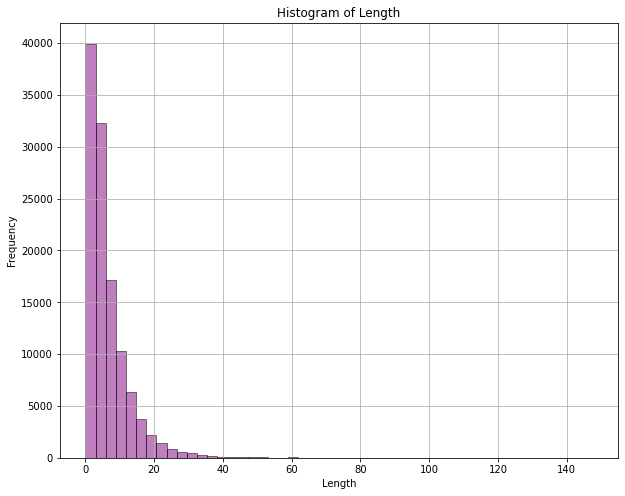

In [62]:
pd.to_numeric(combined['length'], errors='coerce').hist(bins=50, color='purple', alpha=0.5, edgecolor='black',figsize=(10, 8))
plt.title('Histogram of Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

119

In [81]:
from IPython.display import Audio

#find where they are longer than a minute
combined_selection=combined[combined['length'].astype(float) > 10]
print('number of matches:',len(combined_selection))

#llop through 3 of these long files
#for index, row in combined_long.iterrows():
for index, row in combined_selection.head(10).iterrows():
    grade = row['grade']
    student_id = row['student_id']
    true_season = row['true_season']
    task = row['task']
    audio_string = row['audio_string']
    sox_string=audio_string.replace('.wav','_sox_stats.txt')
    sox_path=f'../rer_kaggle/data/sub-{student_id}/ses-{grade}_{true_season}/task-{task}/{sox_string}'
    folder = row['folder']
    display(Audio(f'../rer/Scores/{folder}/{audio_string}'))
    #print(f'../rer/Scores/{folder}/{audio_string}')
    #print(sox_path)
    print(get_stats(sox_path))
    print('\n')

number of matches: 22258


(17, -15.42, -5.26, -20.58, 14.57, 15.319999999999999, 70.0069)




(2, -35.58, -21.33, -52.61, 15.38, 31.28, 7.8023)




(2, -42.52, -28.19, -61.45, 11.58, 33.260000000000005, 10.3627)




(2, -33.51, -18.75, -66.01, 12.52, 47.260000000000005, 9.5847)




(3, -41.27, -25.08, -65.28, 27.79, 40.2, 6.4772)




(2, -29.3, -17.98, -33.66, 18.51, 15.679999999999996, 6.483)




(2, -47.96, -32.04, -333.13, 15.6, 301.09, 7.6923)




(2, -31.95, -18.97, -111.51, 10.44, 92.54, 11.4943)




(2, -37.64, -22.66, -172.8, 13.46, 150.14000000000001, 8.9153)




(4, -27.22, -8.82, -110.96, 12.48, 102.13999999999999, 19.2308)




## Peak RMS
exclude where peak RMS is less than -60

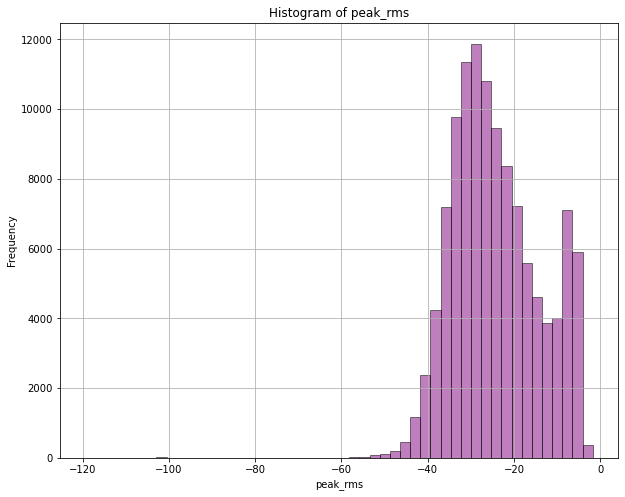

In [51]:
pd.to_numeric(combined['peak_rms'], errors='coerce').hist(bins=50, color='purple', alpha=0.5, edgecolor='black',figsize=(10, 8))
plt.title('Histogram of peak_rms')
plt.xlabel('peak_rms')
plt.ylabel('Frequency')
plt.show()

In [61]:
from IPython.display import Audio

combined_selection=combined[combined['peak_rms'].astype(float) < -60]

#for index, row in combined_long.iterrows():
for index, row in combined_selection.head(5).iterrows():
    grade = row['grade']
    student_id = row['student_id']
    true_season = row['true_season']
    task = row['task']
    audio_string = row['audio_string']
    sox_string=audio_string.replace('.wav','_sox_stats.txt')
    sox_path=f'../rer_kaggle/data/sub-{student_id}/ses-{grade}_{true_season}/task-{task}/{sox_string}'
    folder = row['folder']

    display(Audio(f'../rer/Scores/{folder}/{audio_string}'))
    print(f'../rer/Scores/{folder}/{audio_string}')
    print(sox_path)
    print('\n')

../rer/Scores/20221025/Fall2022Day1G2F1-NonwordRepetitionTaskA2ndFall22-NWR_10_kuhcheyvap_012-11_22_0_4313-22A8A0.wav
../rer_kaggle/data/sub-11_22_0_4313/ses-2_fall/task-NonwordRepetition/Fall2022Day1G2F1-NonwordRepetitionTaskA2ndFall22-NWR_10_kuhcheyvap_012-11_22_0_4313-22A8A0_sox_stats.txt




../rer/Scores/20220311/VirtualWinter2022Day1KF1-NonwordRepetitionTaskAKWinter22-NWR_0122_geemtohf-11_21_0_3531-3B18AB.wav
../rer_kaggle/data/sub-11_21_0_3531/ses-KG_winter/task-NonwordRepetition/VirtualWinter2022Day1KF1-NonwordRepetitionTaskAKWinter22-NWR_0122_geemtohf-11_21_0_3531-3B18AB_sox_stats.txt




../rer/Scores/20220505/VirtualWinter2022Day1G2F1-NonwordRepetitionTaskA2ndWinter22-NWR_0181_boovteypahygfuhdap-66_20_0_2023-4C64D7.wav
../rer_kaggle/data/sub-66_20_0_2023/ses-2_winter/task-NonwordRepetition/VirtualWinter2022Day1G2F1-NonwordRepetitionTaskA2ndWinter22-NWR_0181_boovteypahygfuhdap-66_20_0_2023-4C64D7_sox_stats.txt




../rer/Scores/20220321/VirtualWinter2022Day1KF1-NonwordRepetitionTaskAKWinter22-NWR_0125_kahybeymookdowb-66_21_0_3359-A57469.wav
../rer_kaggle/data/sub-66_21_0_3359/ses-KG_winter/task-NonwordRepetition/VirtualWinter2022Day1KF1-NonwordRepetitionTaskAKWinter22-NWR_0125_kahybeymookdowb-66_21_0_3359-A57469_sox_stats.txt




../rer/Scores/20221130/Fall2022Day1G1F3-NonwordRepetitionTaskB1stFall22-NWR_0165_koovnorb-11_22_0_4564-AC7A39.wav
../rer_kaggle/data/sub-11_22_0_4564/ses-1_fall/task-NonwordRepetition/Fall2022Day1G1F3-NonwordRepetitionTaskB1stFall22-NWR_0165_koovnorb-11_22_0_4564-AC7A39_sox_stats.txt




In [38]:
get_stats('../rer_kaggle/data/sub-11_20_0_2336/ses-2_fall/task-NonwordRepetition/Fall2022Day1G2F1-NonwordRepetitionTaskA2ndFall22-NWR_93_chohfmoonorbkahyheyb_2-11_20_0_2336-907211_sox_stats.txt')

(2, -34.88, -22.71, 'NaN', 5.8, 'NaN', 20.6897)

In [39]:
audio_file = 'path/to/audio/file.mp3'
Audio('../rer_kaggle/data/sub-11_20_0_2336/ses-2_fall/task-NonwordRepetition/Fall2022Day1G2F1-NonwordRepetitionTaskA2ndFall22-NWR_93_chohfmoonorbkahyheyb_2-11_20_0_2336-907211.wav')